In [1]:
import pandas as pd

df = pd.read_csv("../data/creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


SHAPE

In [2]:
print(df.shape)
print(df.columns.tolist())

(284807, 31)
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [3]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [4]:
df.duplicated().sum()

np.int64(1081)

In [5]:
df = df.drop_duplicates()

In [6]:
df["Class"].value_counts(normalize=True)

Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64

Working with regression, XGBoost

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report
)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr.fit(X_train_scaled, y_train)

y_pred_proba = lr.predict_proba(X_val_scaled)[:, 1]
y_pred = lr.predict(X_val_scaled)

print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))
print(classification_report(y_val, y_pred))

ROC-AUC: 0.9656548079701293
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



In [9]:
import xgboost as xgb

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
y_pred_xgb = xgb_model.predict(X_val)

print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba_xgb))
print(classification_report(y_val, y_pred_xgb))

ROC-AUC: 0.969235643166981
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.95      0.79      0.86        95

    accuracy                           1.00     56746
   macro avg       0.97      0.89      0.93     56746
weighted avg       1.00      1.00      1.00     56746



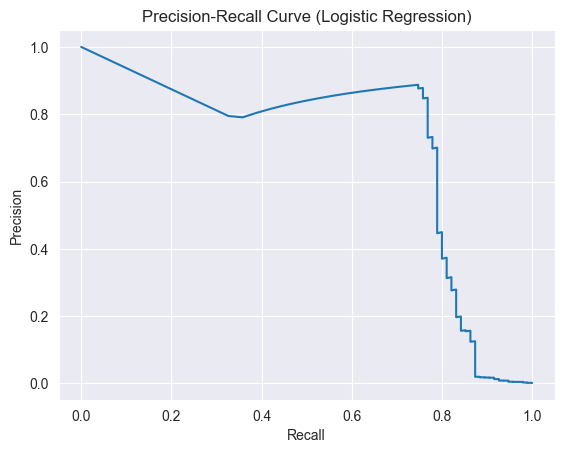

In [11]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.show()

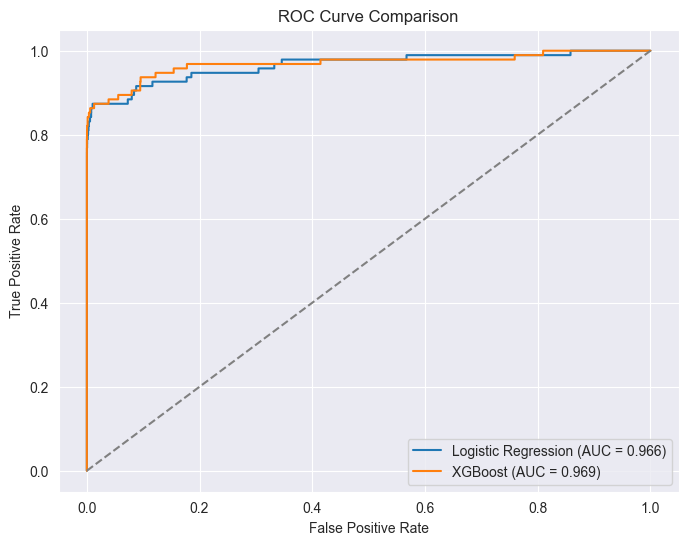

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Logistic regression
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_proba)
auc_lr = roc_auc_score(y_val, y_pred_proba)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()